In [2]:
%pip install transformers
%pip install datasets
%pip install evaluate
%pip install torch

Keyring is skipped due to an exception: 'keyring.backends'
  Using cached transformers-4.24.0-py3-none-any.whl (5.5 MB)
  Using cached tokenizers-0.13.2-cp37-cp37m-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (7.6 MB)
Note: you may need to restart the kernel to use updated packages.
Keyring is skipped due to an exception: 'keyring.backends'
Note: you may need to restart the kernel to use updated packages.
Keyring is skipped due to an exception: 'keyring.backends'
  Using cached evaluate-0.3.0-py3-none-any.whl (72 kB)
Note: you may need to restart the kernel to use updated packages.
Keyring is skipped due to an exception: 'keyring.backends'
  Using cached torch-1.13.0-cp37-cp37m-manylinux1_x86_64.whl (890.2 MB)
  Using cached nvidia_cuda_nvrtc_cu11-11.7.99-2-py3-none-manylinux1_x86_64.whl (21.0 MB)
  Using cached nvidia_cublas_cu11-11.10.3.66-py3-none-manylinux1_x86_64.whl (317.1 MB)
  Using cached nvidia_cudnn_cu11-8.5.0.96-2-py3-none-manylinux1_x86_64.whl (557.1 MB)
  Using cached n

In [3]:
# Some setup to make wordwrap work
from IPython.display import HTML, display

def set_css():
  display(HTML('''
  <style>
    pre {
        white-space: pre-wrap;
    }
  </style>
  '''))
get_ipython().events.register('pre_run_cell', set_css)


In [16]:
from datasets import load_from_disk

subreddit = "subreddit-wallstreetbets"
experiment_name = "sorted_by_upvotes"

# Update this to the dataset you want to load
dataset_path = f"./train_test_{experiment_name}_{subreddit}"

datasets = load_from_disk(dataset_path)


In [5]:
# Some basic data analysis on our utterances
import pandas as pd
utterance_lengths = [len(utterance["utterance"]) for utterance in datasets["train"]]
df = pd.DataFrame(utterance_lengths)
df.describe()

,0
count,2.190130e+06
mean,8.877475e+01
std,8.838668e+01
min,1.000000e+00
25%,2.900000e+01
50%,5.900000e+01
75%,1.150000e+02
max,4.990000e+02


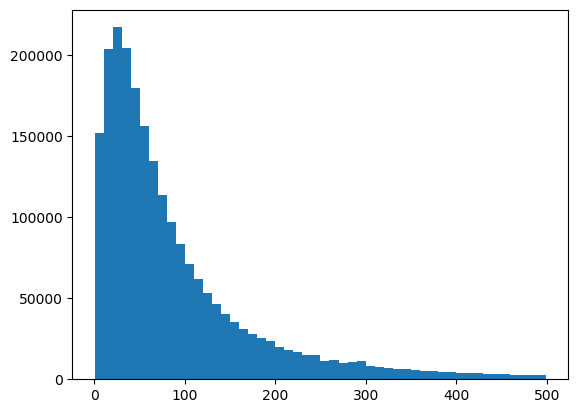

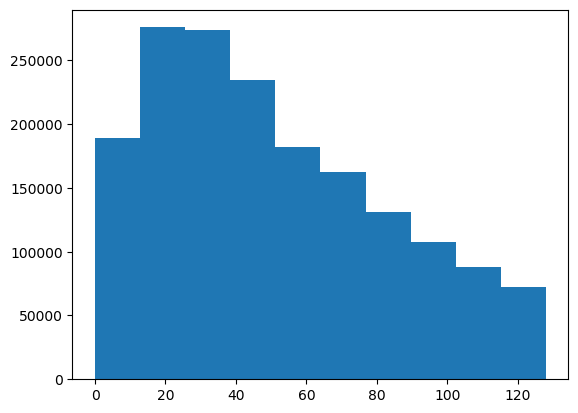

In [6]:
import matplotlib.pyplot as plt


plt.hist(utterance_lengths, bins=50)
plt.show()

plt.hist(utterance_lengths, bins=10, range=(0, 128))
plt.show()

In [7]:
import torch
from transformers import GPT2LMHeadModel
from transformers import GPT2Tokenizer
from transformers import AutoTokenizer

model = GPT2LMHeadModel.from_pretrained("gpt2")

# tokenizer = GPT2Tokenizer.from_pretrained("gpt2", padding_side='left')
tokenizer = AutoTokenizer.from_pretrained("gpt2")
tokenizer.pad_token = tokenizer.eos_token

In [8]:
context_length = 64

def tokenization(utterance):
    outputs = tokenizer(utterance["utterance"], 
                         truncation=False,
                         max_length=context_length,
                         return_overflowing_tokens=True,
                         return_length=True,
                       padding='max_length')
    input_batch = []
    for length, input_ids in zip(outputs["length"], outputs["input_ids"]):
        if length == context_length:
            input_batch.append(input_ids)
    return {"input_ids": input_batch}

In [9]:
tokenized_datasets = datasets.map(tokenization, batched=True, remove_columns=datasets["train"].column_names)

  0%|          | 0/2191 [00:00<?, ?ba/s]

  0%|          | 0/244 [00:00<?, ?ba/s]

In [10]:
# Check # of training examples we have now (since tokenizer could split one input into multiple if it's long)
tokenized_datasets

DatasetDict({
    train: Dataset({
        features: ['input_ids'],
        num_rows: 2053127
    })
    test: Dataset({
        features: ['input_ids'],
        num_rows: 228338
    })
})

In [12]:
from transformers import DataCollatorForLanguageModeling

data_collator = DataCollatorForLanguageModeling(tokenizer, mlm=False) # use CLM

# Sanity check on our dimensions
out = data_collator([tokenized_datasets["train"][i] for i in range(5)])
for key in out:
    print(f"{key} shape: {out[key].shape}")
out = None

input_ids shape: torch.Size([5, 64])
attention_mask shape: torch.Size([5, 64])
labels shape: torch.Size([5, 64])


In [13]:
from huggingface_hub import notebook_login

# Login so we can save our notebook to HuggingFace
notebook_login()


In [14]:
# Just check we have enough space...
!df -h

Filesystem         Size  Used Avail Use% Mounted on
overlay             27G  3.4G   24G  13% /
tmpfs               64M     0   64M   0% /dev
tmpfs              7.7G     0  7.7G   0% /sys/fs/cgroup
shm                1.8G  4.0K  1.8G   1% /dev/shm
127.0.0.1:/200005  8.0E   20G  8.0E   1% /root
/dev/nvme0n1p1     124G   16G  109G  13% /usr/bin/nvidia-smi
devtmpfs           7.7G     0  7.7G   0% /dev/tty
tmpfs              7.7G   12K  7.7G   1% /proc/driver/nvidia
tmpfs              7.7G     0  7.7G   0% /proc/acpi
tmpfs              7.7G     0  7.7G   0% /sys/firmware


In [15]:
# Now you will need to install git-lfs if you're doing checkpointing with HuggingFace
# Follow steps from https://packagecloud.io/github/git-lfs/install

In [19]:
# Run this cell if you are fine-tuning the model that you have already fine-tuned instead of training from GPT2 baseline
from transformers import AutoModel, GPT2Model

ADDITIONAL_FINE_TUNE=False

if ADDITIONAL_FINE_TUNE:
    pretrained_model_path = f"./final_model_output_{subreddit}/"
    model = GPT2LMHeadModel.from_pretrained(pretrained_model_path)

In [ ]:
from transformers import Trainer, TrainingArguments

# Increment if you're further fine-tuning so you don't overwrite your old models
version = 1
output_dir = f"./model_output_{experiment_name}_{subreddit}_{version}"
epochs = 2

args = TrainingArguments(
    output_dir=output_dir,
    per_device_train_batch_size=64,
    per_device_eval_batch_size=64,
    evaluation_strategy="steps",
    eval_steps=5_000,
    logging_steps=8,
    gradient_accumulation_steps=8,
    num_train_epochs=epochs,
    weight_decay=0.1,
    warmup_steps=1_000,
    lr_scheduler_type="cosine",
    learning_rate=5e-4,
    save_strategy="steps",
    save_steps=1_000,
    fp16=True,
    push_to_hub=True,
)

trainer = Trainer(
    model=model,
    tokenizer=tokenizer,
    args=args,
    data_collator=data_collator,
    train_dataset=tokenized_datasets["train"],
    eval_dataset=tokenized_datasets["test"],
)

trainer.train()


PyTorch: setting up devices
The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).
/opt/conda/lib/python3.7/site-packages/huggingface_hub/repository.py:729: FutureWarning: Creating a repository through 'clone_from' is deprecated and will be removed in v0.12. Please create the repository first using `create_repo(..., exists_ok=True)`.
  FutureWarning,
Cloning https://huggingface.co/fanpu/model_output_sorted_by_upvotes_subreddit-wallstreetbets_1 into local empty directory.
Using cuda_amp half precision backend
/opt/conda/lib/python3.7/site-packages/transformers/optimization.py:310: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to dis

Step,Training Loss,Validation Loss
5000,3.787400,3.595925


***** Running Evaluation *****
  Num examples = 228338
  Batch size = 64
Saving model checkpoint to ./model_output_sorted_by_upvotes_subreddit-wallstreetbets_1/checkpoint-5000
Configuration saved in ./model_output_sorted_by_upvotes_subreddit-wallstreetbets_1/checkpoint-5000/config.json
Model weights saved in ./model_output_sorted_by_upvotes_subreddit-wallstreetbets_1/checkpoint-5000/pytorch_model.bin
tokenizer config file saved in ./model_output_sorted_by_upvotes_subreddit-wallstreetbets_1/checkpoint-5000/tokenizer_config.json
Special tokens file saved in ./model_output_sorted_by_upvotes_subreddit-wallstreetbets_1/checkpoint-5000/special_tokens_map.json
tokenizer config file saved in ./model_output_sorted_by_upvotes_subreddit-wallstreetbets_1/tokenizer_config.json
Special tokens file saved in ./model_output_sorted_by_upvotes_subreddit-wallstreetbets_1/special_tokens_map.json


Training completed. Do not forget to share your model on huggingface.co/models =)




TrainOutput(global_step=8020, training_loss=3.6862096467814838, metrics={'train_runtime': 24537.8187, 'train_samples_per_second': 167.344, 'train_steps_per_second': 0.327, 'total_flos': 1.34116202815488e+17, 'train_loss': 3.6862096467814838, 'epoch': 2.0})

In [22]:
trainer.push_to_hub()


Saving model checkpoint to ./model_output_sorted_by_upvotes_subreddit-wallstreetbets_1
Configuration saved in ./model_output_sorted_by_upvotes_subreddit-wallstreetbets_1/config.json
Model weights saved in ./model_output_sorted_by_upvotes_subreddit-wallstreetbets_1/pytorch_model.bin
tokenizer config file saved in ./model_output_sorted_by_upvotes_subreddit-wallstreetbets_1/tokenizer_config.json
Special tokens file saved in ./model_output_sorted_by_upvotes_subreddit-wallstreetbets_1/special_tokens_map.json


Upload file pytorch_model.bin:   0%|          | 32.0k/487M [00:00<?, ?B/s]

remote: Scanning LFS files for validity, may be slow...        
remote: LFS file scan complete.        
To https://huggingface.co/fanpu/model_output_sorted_by_upvotes_subreddit-wallstreetbets_1
   0cf1d4d..6e40ae7  main -> main

Dropping the following result as it does not have all the necessary fields:
{'task': {'name': 'Causal Language Modeling', 'type': 'text-generation'}}
To https://huggingface.co/fanpu/model_output_sorted_by_upvotes_subreddit-wallstreetbets_1
   6e40ae7..d8da5b1  main -> main



'https://huggingface.co/fanpu/model_output_sorted_by_upvotes_subreddit-wallstreetbets_1/commit/6e40ae78927bab6f40728eb7ecda0b9cc10d04d1'

In [18]:
trainer.evaluate()

***** Running Evaluation *****
  Num examples = 228285
  Batch size = 64


{'eval_loss': 3.59867262840271,
 'eval_runtime': 485.7632,
 'eval_samples_per_second': 469.951,
 'eval_steps_per_second': 7.343,
 'epoch': 2.0}